# Beijing Pollution

Third script uses 3 previous lags

In [19]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [20]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# load dataset
dataset = read_csv('./data/pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')


In [21]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
scaled[0:10,:]

array([[0.12977867, 0.35294122, 0.24590163, 0.5272732 , 0.6666667 ,
        0.00229001, 0.        , 0.        ],
       [0.14889336, 0.36764708, 0.24590163, 0.5272732 , 0.6666667 ,
        0.00381099, 0.        , 0.        ],
       [0.15995975, 0.4264706 , 0.22950819, 0.545454  , 0.6666667 ,
        0.00533197, 0.        , 0.        ],
       [0.18209255, 0.48529413, 0.22950819, 0.5636368 , 0.6666667 ,
        0.00839101, 0.03703704, 0.        ],
       [0.13883299, 0.48529413, 0.22950819, 0.5636368 , 0.6666667 ,
        0.00991199, 0.07407407, 0.        ],
       [0.10965794, 0.48529413, 0.21311474, 0.5636368 , 0.6666667 ,
        0.01143297, 0.11111111, 0.        ],
       [0.1056338 , 0.48529413, 0.21311474, 0.5818176 , 0.6666667 ,
        0.01449201, 0.14814815, 0.        ],
       [0.12474848, 0.48529413, 0.22950819, 0.6000004 , 0.6666667 ,
        0.01755106, 0.        , 0.        ],
       [0.12072434, 0.47058827, 0.21311474, 0.6000004 , 0.6666667 ,
        0.0206101 , 0.      

In [27]:
# specify the number of lag hours
n_hours = 1
n_features = 8
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)
print(reframed.shape)

(43799, 16)


In [28]:
reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0
3,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0
4,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0
5,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658,0.485294,0.213115,0.563637,0.666667,0.011433,0.111111,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43795,0.010060,0.264706,0.278689,0.763638,0.333333,0.385730,0.000000,0.0,0.008048,0.250000,0.278689,0.781818,0.333333,0.395659,0.000000,0.0
43796,0.008048,0.250000,0.278689,0.781818,0.333333,0.395659,0.000000,0.0,0.010060,0.264706,0.262295,0.781818,0.333333,0.405588,0.000000,0.0
43797,0.010060,0.264706,0.262295,0.781818,0.333333,0.405588,0.000000,0.0,0.010060,0.264706,0.262295,0.781818,0.333333,0.413996,0.000000,0.0
43798,0.010060,0.264706,0.262295,0.781818,0.333333,0.413996,0.000000,0.0,0.008048,0.264706,0.245902,0.781818,0.333333,0.420866,0.000000,0.0


In [24]:
reframed.head()
reframed.to_csv("test.csv")

In [29]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(8760, 8) 8760 (8760,)
(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)


In [31]:
train_X.shape

(8760, 1, 8)

In [11]:
values[1,]

array([0.14889336, 0.36764708, 0.24590163, 0.5272732 , 0.6666667 ,
       0.00381099, 0.        , 0.        , 0.15995975, 0.4264706 ,
       0.22950819, 0.545454  , 0.6666667 , 0.00533197, 0.        ,
       0.        , 0.18209255, 0.48529413, 0.22950819, 0.5636368 ,
       0.6666667 , 0.00839101, 0.03703704, 0.        , 0.13883299,
       0.48529413, 0.22950819, 0.5636368 , 0.6666667 , 0.00991199,
       0.07407407, 0.        ], dtype=float32)

In [9]:
train_X[0,:,]
#train_X.shape

array([[0.12977867, 0.35294122, 0.24590163, 0.5272732 , 0.6666667 ,
        0.00229001, 0.        , 0.        ],
       [0.14889336, 0.36764708, 0.24590163, 0.5272732 , 0.6666667 ,
        0.00381099, 0.        , 0.        ],
       [0.15995975, 0.4264706 , 0.22950819, 0.545454  , 0.6666667 ,
        0.00533197, 0.        , 0.        ]], dtype=float32)

In [46]:
train_y[0]

0.18209255

In [21]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

Train on 8760 samples, validate on 35037 samples
Epoch 1/50
8760/8760 - 7s - loss: 0.0420 - val_loss: 0.0625
Epoch 2/50
8760/8760 - 4s - loss: 0.0249 - val_loss: 0.0376
Epoch 3/50
8760/8760 - 4s - loss: 0.0212 - val_loss: 0.0264
Epoch 4/50
8760/8760 - 4s - loss: 0.0213 - val_loss: 0.0232
Epoch 5/50
8760/8760 - 4s - loss: 0.0205 - val_loss: 0.0209
Epoch 6/50
8760/8760 - 4s - loss: 0.0202 - val_loss: 0.0199
Epoch 7/50
8760/8760 - 4s - loss: 0.0199 - val_loss: 0.0191
Epoch 8/50
8760/8760 - 4s - loss: 0.0194 - val_loss: 0.0191
Epoch 9/50
8760/8760 - 4s - loss: 0.0191 - val_loss: 0.0183
Epoch 10/50
8760/8760 - 4s - loss: 0.0187 - val_loss: 0.0180
Epoch 11/50
8760/8760 - 4s - loss: 0.0183 - val_loss: 0.0175
Epoch 12/50
8760/8760 - 4s - loss: 0.0177 - val_loss: 0.0173
Epoch 13/50
8760/8760 - 4s - loss: 0.0175 - val_loss: 0.0174
Epoch 14/50
8760/8760 - 4s - loss: 0.0172 - val_loss: 0.0174
Epoch 15/50
8760/8760 - 4s - loss: 0.0168 - val_loss: 0.0178
Epoch 16/50
8760/8760 - 4s - loss: 0.0165 - v

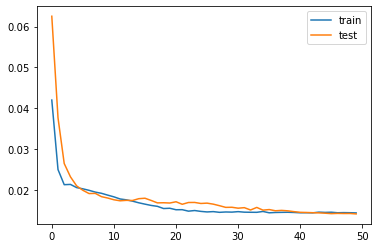

In [22]:
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [23]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -7:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -7:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 26.581
